<a href="https://colab.research.google.com/github/wallace91x/projeto_afinz_wallacelsconceicao/blob/main/Projeto_AfinZ_WallaceLima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Processo Seletivo Área de Crédito - MIS - Management Information System**
#### Candidato: Wallace de Lima da Silva Conceição
#### Afinz - Gerente Thiago Arruda Schumacker




##### O Intuito deste notebook não é somente demonstrar a parte analítica do case, mas também demonstrar toda pipeline de dados e processo ETL de dados. Escolhi fazer desta forma para desmontrar valências buscadas hoje e mencionadas por mim na entrevista.


##### O notebook consiste em sete etapas:
1.   ***Conexão em Data Base criada dentro da AWS.***
2.   ***Criação de tabelas SQL em instância PostgreSQL.***
3.   ***Adaptação do código Oracle para PostgreSQL - Por problemas de software.***
4.   ***Injeção de dados via Python e persistência dos mesmos no DB.***
5.   ***Análise de dados e criação de KPI's via SQL (Queries).***
6.   ***Criação de Gráficos para dataviz.***
7.   ***Considerações Finais e descrição de insights***.




### **Etapa de Injeção de dados via Python e SQL no DB AWS**

##### *Obs.: Realizei a construção de tabelas na AWS seguindo o código enviado para injeção de dados em SQL e a análise dos mesmos dados nesse notebook. Enfrentei dificuldades na instalação e configuração do Oracle em meu computador (ambiente local) e na conexão via Oracle Cloud, bancos que utilizam a sintaxe Oracle SQL enviada. Por esse motivo, tomei a liberdade de manter a mesma estrutura de dados, adaptando apenas a sintaxe para execução em PostgreSQL SQL, hospedado na AWS*


In [ ]:
# Instalação de pacotes necessários à análise
!pip install psycopg2-binary sqlalchemy pandas numpy matplotlib -q

import psycopg2

# Configurações para acesso ao banco de dados AWS
host = "database-afinz.*************.us-east-2.rds.amazonaws.com"
port = 5432
dbname = "post****"
user = "**********"
password = "**********"

# Teste de conexão
try:
    conn = psycopg2.connect(host=host, port=port, dbname=dbname, user=user, password=password)
    print("Conexão realizada com o PostgreSQL na AWS.")
except Exception as e:
    print("Erro de conexão:", e)


Conexão realizada com o PostgreSQL na AWS.


#### **Com a conexão realizada após configuração do AWS Cloud iremos para a injeção de dados que optei ser feita aqui neste notebook utilizando Python + SQL.**

###### Parte 1 - Criação das tabelas

In [ ]:
#Criação das Tabelas no AWS

# FK teve de ser alterada em propostas para referenciar a FK em Carteira
create_tables_sql = """
DROP TABLE IF EXISTS BTESTESQL_PROPOSTAS CASCADE;
CREATE TABLE BTESTESQL_PROPOSTAS (
    DATA_PROPOSTA DATE NOT NULL,
    ID_PROPOSTA NUMERIC PRIMARY KEY,
    STATUS VARCHAR(10) NOT NULL,
    ID_MOTIVO_REPROVACAO NUMERIC,
    SCORE NUMERIC,
    ID_LOJA VARCHAR(6) NOT NULL,
    ID_CONTA VARCHAR(16) UNIQUE,
    LIMITE NUMERIC
);

DROP TABLE IF EXISTS BTESTESQL_FX_SCORE CASCADE;
CREATE TABLE BTESTESQL_FX_SCORE (
    SCORE_INICIO NUMERIC NOT NULL,
    SCORE_FIM NUMERIC NOT NULL,
    FX_SCORE VARCHAR(8) NOT NULL
);

DROP TABLE IF EXISTS BTESTESQL_MOTIVO_REPROV CASCADE;
CREATE TABLE BTESTESQL_MOTIVO_REPROV (
    ID_MOTIVO_REPROVACAO NUMERIC PRIMARY KEY,
    DESCRICAO VARCHAR(20) NOT NULL,
    ID_BUREAU NUMERIC
);

DROP TABLE IF EXISTS BTESTESQL_BUREAU CASCADE;
CREATE TABLE BTESTESQL_BUREAU (
    ID_BUREAU NUMERIC PRIMARY KEY,
    DESCRICAO VARCHAR(8) NOT NULL
);

DROP TABLE IF EXISTS BTESTESQL_LOJA CASCADE;
CREATE TABLE BTESTESQL_LOJA (
    ID_LOJA VARCHAR(6) PRIMARY KEY,
    RAMO_SISTEMA VARCHAR(10) NOT NULL,
    LOJA_UF VARCHAR(2) NOT NULL,
    LOJA_REGIAO VARCHAR(12) NOT NULL
);

DROP TABLE IF EXISTS BTESTESQL_TRANSACOES CASCADE;
CREATE TABLE BTESTESQL_TRANSACOES (
    ID_CONTA VARCHAR(16) NOT NULL,
    ID_TRANSACAO NUMERIC PRIMARY KEY,
    DATA_TRANSACAO DATE NOT NULL,
    VALOR NUMERIC NOT NULL
);

DROP TABLE IF EXISTS BTESTESQL_CARTEIRA CASCADE;
CREATE TABLE BTESTESQL_CARTEIRA (
    REFERENCIA DATE NOT NULL,
    ID_CONTA VARCHAR(16) NOT NULL,
    VCTO_NAO_PAGO DATE,
    ATRASO NUMERIC NOT NULL,
    SALDO NUMERIC NOT NULL,
    PRIMARY KEY (REFERENCIA, ID_CONTA)
);
"""

# Nova conexão ao banco para execução do script
try:
    conn = psycopg2.connect(
        host=host,
        port=port,
        dbname=dbname,
        user=user,
        password=password
    )
    cursor = conn.cursor()
    cursor.execute(create_tables_sql)
    conn.commit()
    print("Todas as tabelas BTESTESQL foram recriadas com sucesso no RDS PostgreSQL AWS!")
except Exception as e:
    print("Erro ao criar tabelas, verificar:", e)
finally:
    cursor.close()
    conn.close()

Todas as tabelas BTESTESQL foram recriadas com sucesso no RDS PostgreSQL AWS!


In [ ]:
# Verificação se as tabelas foram realmente criadas.
conn = psycopg2.connect(
    host="database-afinz.c1cy0qq8ogtr.us-east-2.rds.amazonaws.com",
    port=5432,
    dbname="postgres",
    user="wallacevpg",
    password="2013Vasco*8"
)
cursor = conn.cursor()
cursor.execute("""
SELECT table_name
FROM information_schema.tables
WHERE table_schema = 'public';
""")

tabelas = cursor.fetchall()
print("Tabelas no DB:")
for t in tabelas:
    print("-", t[0])




Tabelas no DB:
- btestesql_bureau
- btestesql_loja
- btestesql_transacoes
- btestesql_carteira
- btestesql_propostas
- btestesql_fx_score
- btestesql_motivo_reprov


##### Parte 2 - Injeção dos dados


In [ ]:
# Parte de injeção dos dados com alteração somente da sintaxe do SQL para Postgree

#Limpeza de dados da tabela se houver

cursor.execute("""
TRUNCATE TABLE
    btestesql_propostas,
    btestesql_carteira,
    btestesql_transacoes,
    btestesql_loja,
    btestesql_motivo_reprov,
    btestesql_fx_score,
    btestesql_bureau
RESTART IDENTITY CASCADE;
""")
conn.commit()

# Preparação dos dados

from datetime import datetime

# Função para converção de data
def conv_data(data_str):
    return datetime.strptime(data_str, '%d/%m/%y').date()

dados_transacoes = [('4092810006145568',10000001,conv_data('03/11/23'),3000),
       ('4092810006932668',10000002,conv_data('08/11/23'),87.9),
       ('4092810006932668',10000003,conv_data('07/11/23'),300),
       ('4092810006932668',10000004,conv_data('14/11/23'),2000.04),
       ('4092810006932668',10000005,conv_data('23/11/23'),81.82),
       ('4092810006932668',10000006,conv_data('01/12/23'),17.45),
       ('4092810007601833',10000007,conv_data('26/01/24'),36),
       ('4092810007509507',10000008,conv_data('22/11/23'),1500),
       ('4092810007509507',10000009,conv_data('08/12/23'),1200),
       ('4092810007536914',10000010,conv_data('16/11/23'),419),
       ('4092810007536914',10000011,conv_data('06/12/23'),124.96),
       ('4092810007536914',10000012,conv_data('05/12/23'),250),
       ('4092810007536914',10000013,conv_data('16/12/23'),24),
       ('4092810007601833',10000014,conv_data('11/11/23'),4219),
       ('4092810007601833',10000015,conv_data('25/01/24'),35),
       ('4092810007601833',10000016,conv_data('25/01/24'),281.45),
       ('4092810007601833',10000017,conv_data('26/01/24'),58),
       ('4092810008365719',10000018,conv_data('28/11/23'),37.69),
       ('4092810008365719',10000019,conv_data('07/12/23'),120),
       ('4092810008365719',10000020,conv_data('04/12/23'),461.36),
       ('4092810008365719',10000021,conv_data('19/12/23'),100.86),
       ('4092810008365719',10000022,conv_data('19/12/23'),163.2),
       ('4092810007753014',10000023,conv_data('14/11/23'),2500.44),
       ('4092810008124850',10000024,conv_data('24/11/23'),540),
       ('4092810008124850',10000025,conv_data('22/11/23'),1959.24),
       ('4092810008124850',10000026,conv_data('27/01/24'),400.2),
       ('4092810008274267',10000027,conv_data('29/11/23'),1700.88),
       ('4092810008556432',10000028,conv_data('05/12/23'),1998.48),
       ('4092810008642257',10000029,conv_data('25/11/23'),1545.06),
       ('4092810008650839',10000030,conv_data('05/12/23'),210.93),
       ('4092810008650839',10000031,conv_data('14/12/23'),9),
       ('4092810008650839',10000032,conv_data('23/12/23'),179.91),
       ('4092810008650839',10000033,conv_data('29/01/24'),20),
       ('4092810008726159',10000034,conv_data('09/12/23'),2820),
       ('4092810008792896',10000035,conv_data('06/12/23'),400),
       ('4092810008814526',10000036,conv_data('29/11/23'),999),
       ('4092810009013664',10000037,conv_data('12/12/23'),129.99),
       ('4092810009013664',10000038,conv_data('12/12/23'),53.82),
       ('4092810009013664',10000039,conv_data('18/12/23'),8.32),
       ('4092810009013664',10000040,conv_data('09/01/24'),169.92),
       ('4092810009013664',10000041,conv_data('19/02/24'),260.54),
       ('4092810009133546',10000042,conv_data('06/12/23'),600),
       ('4092810009047944',10000043,conv_data('08/12/23'),400),
       ('4092810009075259',10000044,conv_data('18/12/23'),400),
       ('4092810009075259',10000045,conv_data('14/01/24'),29.99),
       ('4092810009075259',10000046,conv_data('23/01/24'),44.27),
       ('4092810009075259',10000047,conv_data('22/01/24'),26.19),
       ('4092810009075259',10000048,conv_data('17/02/24'),100),
       ('4092810009369371',10000049,conv_data('20/12/23'),1103.68),
       ('4092810009369371',10000050,conv_data('19/02/24'),8.5),
       ('4092810009369371',10000051,conv_data('19/02/24'),75),
       ('4092810009764944',10000052,conv_data('18/12/23'),3000),
       ('4092810009867796',10000053,conv_data('18/12/23'),356.94),
       ('4092810009872986',10000054,conv_data('27/12/23'),3060),
       ('4092810009872986',10000055,conv_data('26/01/24'),55.9),
       ('4092810009872986',10000056,conv_data('19/02/24'),40),
       ('4092810009872986',10000057,conv_data('19/02/24'),283.5),
       ('4092810009981498',10000058,conv_data('28/12/23'),400),
       ('4092810000218237',10000059,conv_data('22/12/23'),609.74),
       ('4092810000218237',10000060,conv_data('04/01/24'),76.78),
       ('4092810008387016',10000061,conv_data('30/12/23'),169.9),
       ('4092810008380607',10000062,conv_data('13/12/23'),46.68),
       ('4092810008380607',10000063,conv_data('13/12/23'),386.7),
       ('4092810008387016',10000064,conv_data('11/12/23'),299)]

dados_bureau = [(1, 'Bureau 1'),
    (2, 'Bureau 2')]

dados_loja = [('0(T201', 'Ramo 5', 'SP', 'Sudeste'),
('5(SU05', 'Ramo 6', 'PE', 'Nordeste'),
('5(S007', 'Ramo 6', 'BA', 'Nordeste'),
('UDSZ01', 'Ramo 3', 'BA', 'Nordeste'),
('2D2(16', 'Ramo 4', 'BA', 'Nordeste'),
('5(SU12', 'Ramo 6', 'MA', 'Nordeste'),
('12OC33', 'Ramo 4', 'SP', 'Sudeste'),
('IJ--01', 'Ramo 2', 'SP', 'Sudeste'),
('G95901', 'Ramo 6', 'SP', 'Sudeste'),
('TW-N42', 'Ramo 4', 'BA', 'Nordeste'),
('5RW]09', 'Ramo 4', 'CE', 'Nordeste'),
('4(SB03', 'Ramo 4', 'BA', 'Nordeste'),
('4-S-01', 'Ramo 4', 'ES', 'Sudeste'),
('5(SV02', 'Ramo 6', 'PE', 'Nordeste'),
('2D2(01', 'Ramo 4', 'BA', 'Nordeste'),
('5RW]03', 'Ramo 4', 'CE', 'Nordeste'),
('TW-N37', 'Ramo 4', 'ES', 'Sudeste'),
('Z-TW08', 'Ramo 4', 'BA', 'Nordeste'),
('5(SV04', 'Ramo 6', 'PE', 'Nordeste'),
('3WCL38', 'Ramo 4', 'DF', 'Centro-Oeste'),
('E(W601', 'Ramo 1', 'SP', 'Sudeste'),
('5(SU27', 'Ramo 6', 'RN', 'Nordeste'),
('4(UI01', 'Ramo 4', 'BA', 'Nordeste'),
('5H(W15', 'Ramo 4', 'BA', 'Nordeste'),
('3WCL21', 'Ramo 4', 'GO', 'Centro-Oeste'),
('0Q8101', 'Ramo 4', 'RJ', 'Sudeste'),
('5(TW17', 'Ramo 4', 'PE', 'Nordeste'),
('87-F01', 'Ramo 2', 'RS', 'Sul'),
('5(SV06', 'Ramo 6', 'PE', 'Nordeste'),
('5H(W44', 'Ramo 4', 'BA', 'Nordeste'),
('5(SU31', 'Ramo 6', 'PE', 'Nordeste'),
('2D2(17', 'Ramo 4', 'BA', 'Nordeste'),
('5(M113', 'Ramo 4', 'CE', 'Nordeste'),
('8NK[09', 'Ramo 4', 'BA', 'Nordeste'),
('OS(604', 'Ramo 4', 'CE', 'Nordeste'),
('5(RN01', 'Ramo 4', 'BA', 'Nordeste'),
('5H(W37', 'Ramo 4', 'BA', 'Nordeste'),
('T-4-01', 'Ramo 5', 'RS', 'Sul'),
('!4W401', 'Ramo 2', 'SP', 'Sudeste'),
('3WCL33', 'Ramo 4', 'GO', 'Centro-Oeste'),
('6(U801', 'Ramo 2', 'PR', 'Sul'),
('5(SU07', 'Ramo 6', 'MA', 'Nordeste'),
('5(SU08', 'Ramo 6', 'MA', 'Nordeste'),
('3WCL15', 'Ramo 4', 'DF', 'Centro-Oeste'),
('5(TM15', 'Ramo 4', 'RJ', 'Sudeste'),
('5(SU18', 'Ramo 6', 'PB', 'Nordeste'),
('5(SV05', 'Ramo 6', 'PE', 'Nordeste'),
('5(TW41', 'Ramo 4', 'PE', 'Nordeste'),
('FYU]02', 'Ramo 4', 'CE', 'Nordeste'),
('5(S006', 'Ramo 6', 'BA', 'Nordeste'),
('5(SU17', 'Ramo 6', 'PB', 'Nordeste'),
('59G!01', 'Ramo 2', 'SC', 'Sul'),
('5(SU25', 'Ramo 6', 'SE', 'Nordeste'),
('Z-TW48', 'Ramo 4', 'BA', 'Nordeste'),
('5RW]13', 'Ramo 4', 'CE', 'Nordeste'),
('0(7V03', 'Ramo 4', 'BA', 'Nordeste'),
('Z-TW35', 'Ramo 4', 'BA', 'Nordeste'),
('VX)W01', 'Ramo 2', 'MT', 'Centro-Oeste'),
('5(SU01', 'Ramo 6', 'PE', 'Nordeste'),
('5(TM30', 'Ramo 4', 'RJ', 'Sudeste'),
('5(SU24', 'Ramo 6', 'PB', 'Nordeste'),
('5(TW39', 'Ramo 4', 'PE', 'Nordeste'),
('OS(649', 'Ramo 4', 'CE', 'Nordeste'),
('JIU]01', 'Ramo 4', 'BA', 'Nordeste'),
('3WCL10', 'Ramo 4', 'DF', 'Centro-Oeste'),
('5(Q001', 'Ramo 4', 'BA', 'Nordeste'),
('TW-N06', 'Ramo 4', 'ES', 'Sudeste'),
('12OC34', 'Ramo 4', 'SP', 'Sudeste'),
('5H(W33', 'Ramo 4', 'BA', 'Nordeste'),
('TW-N26', 'Ramo 4', 'ES', 'Sudeste'),
('5(SU11', 'Ramo 6', 'MA', 'Nordeste'),
('-6TD01', 'Ramo 2', 'SP', 'Sudeste'),
('4(T901', 'Ramo 2', 'RJ', 'Sudeste'),
('5(S001', 'Ramo 6', 'BA', 'Nordeste'),
('5(TM24', 'Ramo 4', 'RJ', 'Sudeste'),
('5(S003', 'Ramo 6', 'BA', 'Nordeste'),
('2D2(18', 'Ramo 4', 'BA', 'Nordeste'),
('T9M207', 'Ramo 4', 'BA', 'Nordeste'),
('TIF(11', 'Ramo 4', 'ES', 'Sudeste'),
('TIF(02', 'Ramo 4', 'BA', 'Nordeste'),
('2D2(33', 'Ramo 4', 'BA', 'Nordeste'),
('2D2(07', 'Ramo 4', 'BA', 'Nordeste'),
('5(TM38', 'Ramo 4', 'RJ', 'Sudeste'),
('5(U501', 'Ramo 4', 'ES', 'Sudeste'),
('Z-TW12', 'Ramo 4', 'BA', 'Nordeste'),
('5H(W22', 'Ramo 4', 'BA', 'Nordeste')]

dados_carteira = [(conv_data('31/01/24'), '4092810006145568', conv_data('03/12/23'), 59, 2020.99),
       (conv_data('31/01/24'), '4092810006932668', None, 0, 1692.19),
       (conv_data('31/12/23'), '4092810007509507', None, 0, 2550),
       (conv_data('31/12/23'), '4092810007536914', conv_data('16/12/23'), 15, 845.54),
       (conv_data('31/01/24'), '4092810008274267', None, 0, 1416.6),
       (conv_data('31/12/23'), '4092810008726159', None, 0, 2820),
       (conv_data('31/01/24'), '4092810009764944', None, 0, 2750),
       (conv_data('31/01/24'), '4092810007509507', None, 0, 2280),
       (conv_data('30/11/23'), '4092810007536914', None, 0, 423.03),
       (conv_data('31/01/24'), '4092810008124850', conv_data('22/12/23'), 40, 2538.15),
       (conv_data('31/12/23'), '4092810008792896', None, 0, 400),
       (conv_data('31/12/23'), '4092810006145568', conv_data('03/12/23'), 28, 2520.99),
       (conv_data('31/01/24'), '4092810008365719', None, 0, 1276.99),
       (conv_data('31/01/24'), '4092810009075259', None, 0, 70.46),
       (conv_data('31/12/23'), '4092810009133546', None, 0, 600),
       (conv_data('31/01/24'), '4092810009872986', conv_data('27/01/24'), 4, 2860.9),
       (conv_data('31/01/24'), '4092810007536914', conv_data('16/12/23'), 46, 571.62),
       (conv_data('31/01/24'), '4092810007601833', None, 0, 4326.41),
       (conv_data('31/01/24'), '4092810007753014', None, 0, 2083.3),
       (conv_data('31/12/23'), '4092810008556432', None, 0, 1831.94),
       (conv_data('31/12/23'), '4092810009764944', None, 0, 3000),
       (conv_data('31/01/24'), '4092810008387016', conv_data('11/01/24'), 20, 526.97),
       (conv_data('31/12/23'), '4092810008642257', conv_data('25/12/23'), 6, 1287.5),
       (conv_data('31/01/24'), '4092810008642257', conv_data('25/12/23'), 37, 1030),
       (conv_data('31/12/23'), '4092810008650839', None, 0, 399.84),
       (conv_data('31/01/24'), '4092810009369371', None, 0, 965.44),
       (conv_data('31/12/23'), '4092810009867796', None, 0, 356.94),
       (conv_data('31/12/23'), '4092810009872986', None, 0, 3060),
       (conv_data('31/01/24'), '4092810009981498', None, 0, 368.52),
       (conv_data('31/01/24'), '4092810000218237', None, 0, 607.94),
       (conv_data('31/12/23'), '4092810008380607', None, 0, 433.38),
       (conv_data('31/12/23'), '4092810008274267', None, 0, 1589.31),
       (conv_data('31/01/24'), '4092810008792896', None, 0, 300),
       (conv_data('31/01/24'), '4092810008814526', None, 0, 924.58),
       (conv_data('31/12/23'), '4092810009013664', None, 0, 192.13),
       (conv_data('31/01/24'), '4092810009013664', None, 0, 285.26),
       (conv_data('31/01/24'), '4092810009133546', None, 0, 480),
       (conv_data('31/12/23'), '4092810000218237', None, 0, 619.98),
       (conv_data('31/01/24'), '4092810008380607', None, 0, 360.8),
       (conv_data('31/12/23'), '4092810008387016', None, 0, 303.09),
       (conv_data('31/12/23'), '4092810006932668', None, 0, 1402.12),
       (conv_data('31/12/23'), '4092810007601833', None, 0, 3797.1),
       (conv_data('31/12/23'), '4092810007753014', None, 0, 2327.36),
       (conv_data('31/12/23'), '4092810008124850', conv_data('22/12/23'), 9, 2116.69),
       (conv_data('31/12/23'), '4092810008365719', None, 0, 685.66),
       (conv_data('31/01/24'), '4092810008556432', None, 0, 1665.4),
       (conv_data('31/01/24'), '4092810008726159', None, 0, 2593.29),
       (conv_data('31/12/23'), '4092810008814526', None, 0, 925.64),
       (conv_data('31/12/23'), '4092810009047944', None, 0, 400),
       (conv_data('31/12/23'), '4092810009369371', None, 0, 1103.68),
       (conv_data('31/01/24'), '4092810009867796', None, 0, 237.92),
       (conv_data('31/01/24'), '4092810008650839', conv_data('05/01/24'), 26, 280.52),
       (conv_data('31/01/24'), '4092810009047944', None, 0, 320),
       (conv_data('31/12/23'), '4092810009075259', None, 0, 414.7)]

dados_propostas =[(conv_data('29/11/23'), 200000453771, 'EFETIVADO', None, 907, 'T-4-01', '4092810008274267', 1700),
       (conv_data('11/11/23'), 200000332798, 'EFETIVADO', None, 930, '3WCL21', '4092810007601833', 5625),
       (conv_data('18/12/23'), 200000586520, 'EFETIVADO', None, 906, '!4W401', '4092810009764944', 5625),
       (conv_data('09/12/23'), 200000523594, 'EFETIVADO', None, 903, '12OC33', '4092810008726159', 3000),
       (conv_data('18/12/23'), 200000586697, 'EFETIVADO', None, 901, '5(SU11', '4092810009867796', 1500),
       (conv_data('27/12/23'), 200000649818, 'EFETIVADO', None, 916, 'IJ--01', '4092810009872986', 6000),
       (conv_data('21/11/23'), 200000393539, 'EFETIVADO', None, 905, 'VX)W01', '4092810007509507', 3000),
       (conv_data('03/11/23'), 200000287166, 'EFETIVADO', None, 951, '3WCL33', '4092810006145568', 3000),
       (conv_data('20/12/23'), 200000599087, 'EFETIVADO', None, 902, 'G95901', '4092810009369371', 1500),
       (conv_data('25/11/23'), 200000426192, 'EFETIVADO', None, 856, '0(T201', '4092810008642257', 1700),
       (conv_data('11/12/23'), 200000535079, 'EFETIVADO', None, 802, 'Z-TW08', '4092810008387016', 1500),
       (conv_data('14/11/23'), 200000351898, 'EFETIVADO', None, 855, '!4W401', '4092810007753014', 2500),
       (conv_data('29/11/23'), 200000452111, 'EFETIVADO', None, 798, '6(U801', '4092810008814526', 2000),
       (conv_data('16/11/23'), 200000360060, 'EFETIVADO', None, 730, '0Q8101', '4092810007536914', 1000),
       (conv_data('05/12/23'), 200000492541, 'ABANDONO', None, 791, 'TW-N42', None, 6000),
       (conv_data('13/12/23'), 200000551090, 'EFETIVADO', None, 655, '5(TW17', '4092810008380607', 1200),
       (conv_data('18/12/23'), 200000584823, 'EFETIVADO', None, 639, '5(SV04', '4092810009075259', 400),
       (conv_data('06/12/23'), 200000497621, 'EFETIVADO', None, 633, '5(SU17', '4092810008792896', 400),
       (conv_data('03/11/23'), 200000286321, 'EFETIVADO', None, 667, '-6TD01', '4092810006932668', 2500),
       (conv_data('28/12/23'), 200000654076, 'EFETIVADO', None, 652, '5(SU01', '4092810009981498', 400),
       (conv_data('27/11/23'), 200000438565, 'ABANDONO', None, 680, '5(TM30', None, 1200),
       (conv_data('22/11/23'), 200000398029, 'EFETIVADO', None, 598, '59G!01', '4092810008124850', 2500),
       (conv_data('06/12/23'), 200000498490, 'EFETIVADO', None, 594, '5(SU07', '4092810009133546', 600),
       (conv_data('08/12/23'), 200000513245, 'EFETIVADO', None, 600, '5(SU05', '4092810009047944', 400),
       (conv_data('22/11/23'), 200000397856, 'EFETIVADO', None, 576, '4(T901', '4092810008365719', 2500),
       (conv_data('05/12/23'), 200000489335, 'EFETIVADO', None, 598, '5(S001', '4092810008650839', 400),
       (conv_data('12/12/23'), 200000538152, 'EFETIVADO', None, 595, '5(SU08', '4092810009013664', 400),
       (conv_data('05/12/23'), 200000494679, 'EFETIVADO', None, 586, '87-F01', '4092810008556432', 2500),
       (conv_data('22/12/23'), 200000618781, 'EFETIVADO', None, 594, '5(S007', '4092810000218237', 800),
       (conv_data('27/11/23'), 200000435267, 'ABANDONO', None, 595, '3WCL38', None, 1500),
       (conv_data('06/12/23'), 200000498311, 'REPROVADO', 3, None, '3WCL15', None, None),
       (conv_data('17/12/23'), 200000578601, 'REPROVADO', 3, None, '5(SV06', None, None),
       (conv_data('09/11/23'), 200000317853, 'REPROVADO', 3, None, '5(TM24', None, None),
       (conv_data('21/12/23'), 200000609654, 'REPROVADO', 3, None, 'UDSZ01', None, None),
       (conv_data('24/11/23'), 200000417271, 'REPROVADO', 3, None, '5H(W44', None, None),
       (conv_data('14/12/23'), 200000554966, 'REPROVADO', 3, None, '5(SU25', None, None),
       (conv_data('07/12/23'), 200000505594, 'REPROVADO', 3, None, '5(S003', None, None),
       (conv_data('20/11/23'), 200000379704, 'REPROVADO', 3, None, '2D2(16', None, None),
       (conv_data('01/11/23'), 200000275445, 'REPROVADO', 3, None, '5(TM15', None, None),
       (conv_data('19/12/23'), 200000588646, 'REPROVADO', 3, None, '2D2(18', None, None),
       (conv_data('16/12/23'), 200000573079, 'REPROVADO', 3, None, '5(SU24', None, None),
       (conv_data('27/11/23'), 200000431892, 'REPROVADO', 4, None, '5(SU18', None, None),
       (conv_data('26/12/23'), 200000642203, 'REPROVADO', 4, None, '5RW]09', None, None),
       (conv_data('12/12/23'), 200000544234, 'REPROVADO', 4, None, '5(TW39', None, None),
       (conv_data('15/12/23'), 200000564724, 'REPROVADO', 4, None, 'E(W601', None, None),
       (conv_data('20/11/23'), 200000379539, 'REPROVADO', 4, None, '5(S007', None, None),
       (conv_data('29/12/23'), 200000668968, 'REPROVADO', 4, None, '4(SB03', None, None),
       (conv_data('24/11/23'), 200000419928, 'REPROVADO', 4, None, '5(SU31', None, None),
       (conv_data('25/11/23'), 200000424381, 'REPROVADO', 2, 620, '2D2(17', None, None),
       (conv_data('03/11/23'), 200000286342, 'REPROVADO', 2, 607, '4-S-01', None, None),
       (conv_data('24/11/23'), 200000416745, 'REPROVADO', 2, 524, '4(SB03', None, None),
       (conv_data('21/11/23'), 200000387168, 'REPROVADO', 2, 539, 'Z-TW48', None, None),
       (conv_data('13/11/23'), 200000340422, 'REPROVADO', 2, 591, 'OS(649', None, None),
       (conv_data('17/11/23'), 200000369988, 'REPROVADO', 2, 454, '5(SV05', None, None),
       (conv_data('08/12/23'), 200000516376, 'REPROVADO', 2, 486, 'T9M207', None, None),
       (conv_data('13/12/23'), 200000553130, 'REPROVADO', 2, 599, 'TIF(11', None, None),
       (conv_data('20/12/23'), 200000598353, 'REPROVADO', 2, 502, '5(SU27', None, None),
       (conv_data('12/12/23'), 200000544424, 'REPROVADO', 2, 527, 'JIU]01', None, None),
       (conv_data('27/11/23'), 200000436101, 'REPROVADO', 2, 438, '3WCL10', None, None),
       (conv_data('22/11/23'), 200000395125, 'REPROVADO', 2, 497, '4(SB03', None, None),
       (conv_data('18/11/23'), 200000375582, 'REPROVADO', 2, 633, '5(SV02', None, None),
       (conv_data('09/12/23'), 200000521911, 'REPROVADO', 2, 615, '2D2(01', None, None),
       (conv_data('22/12/23'), 200000617299, 'REPROVADO', 2, 423, '5(M113', None, None),
       (conv_data('28/11/23'), 200000446043, 'REPROVADO', 2, 335, '4(UI01', None, None),
       (conv_data('23/12/23'), 200000626185, 'REPROVADO', 2, 596, '8NK[09', None, None),
       (conv_data('16/12/23'), 200000575935, 'REPROVADO', 2, 544, '5(S001', None, None),
       (conv_data('11/12/23'), 200000536363, 'REPROVADO', 2, 466, 'TIF(02', None, None),
       (conv_data('11/11/23'), 200000332135, 'REPROVADO', 2, 635, '8NK[09', None, None),
       (conv_data('02/12/23'), 200000473682, 'REPROVADO', 1, 476, 'OS(604', None, None),
       (conv_data('02/12/23'), 200000476311, 'REPROVADO', 1, 405, '5(RN01', None, None),
       (conv_data('09/12/23'), 200000521365, 'REPROVADO', 1, 457, '5(Q001', None, None),
       (conv_data('23/12/23'), 200000628149, 'REPROVADO', 1, 487, 'T9M207', None, None),
       (conv_data('27/12/23'), 200000645712, 'REPROVADO', 1, 476, '5RW]13', None, None),
       (conv_data('21/12/23'), 200000605255, 'REPROVADO', 1, 397, '5(S001', None, None),
       (conv_data('06/12/23'), 200000502809, 'REPROVADO', 1, 333, '2D2(33', None, None),
       (conv_data('06/12/23'), 200000500988, 'REPROVADO', 1, 335, '2D2(07', None, None),
       (conv_data('22/11/23'), 200000397772, 'REPROVADO', 1, 386, '5(TM38', None, None),
       (conv_data('18/11/23'), 200000374046, 'REPROVADO', 1, 370, '5(U501', None, None),
       (conv_data('13/12/23'), 200000547574, 'REPROVADO', 1, 394, '0(7V03', None, None),
       (conv_data('23/11/23'), 200000403728, 'REPROVADO', 1, 230, 'TW-N06', None, None),
       (conv_data('23/11/23'), 200000403701, 'REPROVADO', 1, 250, '5RW]03', None, None),
       (conv_data('20/12/23'), 200000599973, 'REPROVADO', 1, 291, 'Z-TW12', None, None),
       (conv_data('20/12/23'), 200000599761, 'REPROVADO', 1, 291, '5H(W22', None, None),
       (conv_data('13/12/23'), 200000550638, 'REPROVADO', 1, 108, '5(SU12', None, None),
       (conv_data('04/12/23'), 200000480650, 'REPROVADO', 1, 178, '2D2(16', None, None),
       (conv_data('18/12/23'), 200000583434, 'REPROVADO', 1, 199, 'Z-TW35', None, None),
       (conv_data('28/12/23'), 200000658967, 'REPROVADO', 1, 1, '5(TW41', None, None),
       (conv_data('01/12/23'), 200000470346, 'REPROVADO', 1, 98, '5H(W15', None, None),
       (conv_data('25/11/23'), 200000426125, 'REPROVADO', 1, 40, 'FYU]02', None, None),
       (conv_data('12/12/23'), 200000541989, 'REPROVADO', 1, 11, '5(S001', None, None),
       (conv_data('22/12/23'), 200000620128, 'REPROVADO', 1, 40, '5(SU24', None, None),
       (conv_data('29/12/23'), 200000672975, 'REPROVADO', 1, 73, '12OC34', None, None),
       (conv_data('05/12/23'), 200000492272, 'REPROVADO', 1, 30, '2D2(01', None, None),
       (conv_data('11/11/23'), 200000333278, 'REPROVADO', 1, 39, '5H(W37', None, None),
       (conv_data('12/12/23'), 200000539942, 'REPROVADO', 1, 78, '5(TW39', None, None),
       (conv_data('26/12/23'), 200000641177, 'REPROVADO', 1, 43, '5H(W33', None, None),
       (conv_data('28/12/23'), 200000659775, 'REPROVADO', 1, 40, 'TW-N37', None, None),
       (conv_data('11/12/23'), 200000530236, 'REPROVADO', 1, 79, 'TW-N26', None, None),
       (conv_data('13/12/23'), 200000552766, 'REPROVADO', 1, 95, '5(S006', None, None),
       (conv_data('30/11/23'), 200000458831, 'REPROVADO', 1, 31, '5(S003', None, None)]

dados_fx_score = [(901, 1000, 'Faixa 1'),
       (801, 900, 'Faixa 2'),
       (701, 800, 'Faixa 3'),
       (601, 700, 'Faixa 4'),
       (501, 600, 'Faixa 5'),
       (401, 500, 'Faixa 6'),
       (301, 400, 'Faixa 7'),
       (201, 300, 'Faixa 8'),
       (101, 200, 'Faixa 9'),
       (1, 100, 'Faixa 10')]

dados_motivo_reprov = [(1, 'Ponto de Corte', None),
      (2, 'Politica de Credito', None),
      (3, 'Negativado', 1),
      (4, 'Negativado', 2)]

# Injeção dos dados

conn = psycopg2.connect(
    host=host,
    port=port,
    dbname=dbname,
    user=user,
    password=password
)
cursor = conn.cursor()

# Injeção na tabela BTESTESQL_LOJA
cursor.executemany("""
INSERT INTO btestesql_loja (id_loja, ramo_sistema, loja_uf, loja_regiao)
VALUES (%s, %s, %s, %s)
""", dados_loja)

# Injeção na tabela BTESTESQL_MOTIVO_REPROV
cursor.executemany("""
INSERT INTO btestesql_motivo_reprov (id_motivo_reprovacao, descricao, id_bureau)
VALUES (%s, %s, %s)
""", dados_motivo_reprov)

# Injeção na tabela BTESTESQL_FX_SCORE
cursor.executemany("""
INSERT INTO btestesql_fx_score (score_inicio, score_fim, fx_score)
VALUES (%s, %s, %s)
""", dados_fx_score)

# Injeção na tabela BTESTESQL_BUREAU
cursor.executemany("""
INSERT INTO btestesql_bureau (id_bureau, descricao)
VALUES (%s, %s)
""", dados_bureau)

# Injeção na tabela BTESTESQL_PROPOSTAS
cursor.executemany("""
INSERT INTO btestesql_propostas (data_proposta, id_proposta, status, id_motivo_reprovacao, score, id_loja, id_conta, limite)
VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
""", dados_propostas)

# Injeção na tabela BTESTESQL_CARTEIRA
cursor.executemany("""
INSERT INTO btestesql_carteira (referencia, id_conta, vcto_nao_pago, atraso, saldo)
VALUES (%s, %s, %s, %s, %s)
""", dados_carteira)

# Injeção na tabela BTESTESQL_TRANSACOES
cursor.executemany("""
INSERT INTO btestesql_transacoes (id_conta, id_transacao, data_transacao, valor)
VALUES (%s, %s, %s, %s)
""", dados_transacoes)

try:
  conn.commit()
  print("Dados inseridos em todas as tabelas com sucesso!")
except Exception as e:
  print("Erro ao inserir dados, verificar:", e)


Dados inseridos em todas as tabelas com sucesso!


In [ ]:
# Verificação de persistência dos dados inseridos na AWS

import psycopg2
import pandas as pd

conn = psycopg2.connect(
    host=host,
    port=port,
    dbname=dbname,
    user=user,
    password=password
)
cursor = conn.cursor()

# Tabelas criadas
tabelas = [
    "btestesql_loja",
    "btestesql_motivo_reprov",
    "btestesql_fx_score",
    "btestesql_bureau",
    "btestesql_propostas",
    "btestesql_carteira",
    "btestesql_transacoes"
]

# Verificando dados - 10 Linhas por tabela (Para mais linhas ou tabela inteira, somente retirar 'LIMIT 10')

for tabela in tabelas:
    cursor.execute(f"SELECT * FROM {tabela} LIMIT 10;")
    rows = cursor.fetchall()
    colnames = [desc[0] for desc in cursor.description]
    print(f"\n Tabela: {tabela}")
    df = pd.DataFrame(rows, columns=colnames)
    print(df)




 Tabela: btestesql_loja
  id_loja ramo_sistema loja_uf loja_regiao
0  0(T201       Ramo 5      SP     Sudeste
1  5(SU05       Ramo 6      PE    Nordeste
2  5(S007       Ramo 6      BA    Nordeste
3  UDSZ01       Ramo 3      BA    Nordeste
4  2D2(16       Ramo 4      BA    Nordeste
5  5(SU12       Ramo 6      MA    Nordeste
6  12OC33       Ramo 4      SP     Sudeste
7  IJ--01       Ramo 2      SP     Sudeste
8  G95901       Ramo 6      SP     Sudeste
9  TW-N42       Ramo 4      BA    Nordeste

 Tabela: btestesql_motivo_reprov
  id_motivo_reprovacao            descricao id_bureau
0                    1       Ponto de Corte      None
1                    2  Politica de Credito      None
2                    3           Negativado         1
3                    4           Negativado         2

 Tabela: btestesql_fx_score
  score_inicio score_fim  fx_score
0          901      1000   Faixa 1
1          801       900   Faixa 2
2          701       800   Faixa 3
3          601       700   Fa

#### Parte 3 - Montagem do esquema Relacional Proposto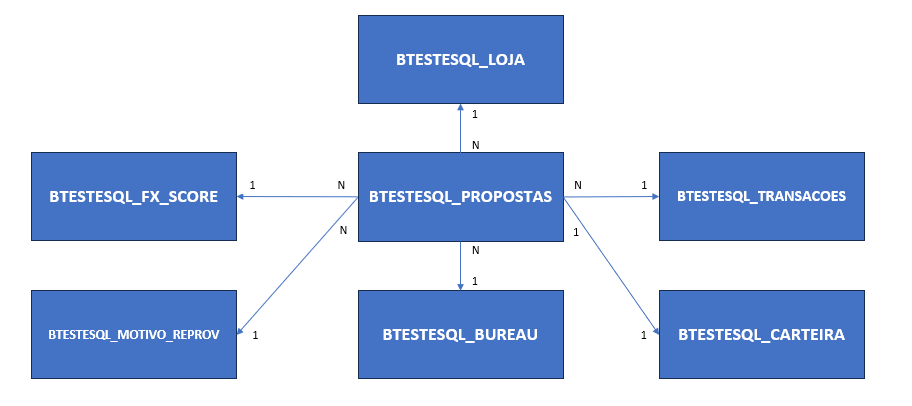

#### Observações e algumas dúvidas sobre o esquema:


##### **Obs 1.:** O esquema me parece ter um erro na relação Propostas e Transações sendo ou:
##### N para N (Se uma transação feita em data X ainda esta´aberta e influencia a carteira de mais de um mês) - porém ID_CONTA é único o que anularia essa premissa ou  
##### 1 para N (se cada transação pertencer a uma única conta) respectivamente e não N para 1. Essa me parece mais provável.

##### **Obs 2.:** A relação (de acordo com PK e FK das tabelas) entre BTESTESQL_BUREAU e BTESTESQL_PROPOSTA aparentemente não é direta e sim indireta com conexão entre BTESTESQL_BUREAU e BTESTESQL_MOTIVO_REPROV e este último sim com conexão a BTESTESQL_PROPOSTA. Para o KPI pedido, não entendo ser problema a conexão dessa forma.

##### **Obs 3.:** A relação (de acordo com PK e FK das tabelas) entre BTESTESQL_CARTEIRA e BTESTESQL_PROPOSTA aparentemente não é de 1 para 1 e sim de 1:N (um proposta pode ter várias linhas na carteira ao longo do tempo). Por isto até a PK composta em BTESTESQL_CARTEIRA.


In [ ]:
create_view_sql = """
CREATE OR REPLACE VIEW vw_kpi_base AS
SELECT
    p.id_proposta,
    p.data_proposta,
    p.status,
    p.score,
    p.id_conta,
    p.limite,
    l.ramo_sistema,
    m.descricao AS motivo_reprovacao,
    b.descricao AS bureau,
    c.referencia,
    c.saldo,
    c.atraso,
    DATE_PART('month', AGE(c.referencia, p.data_proposta)) AS mob,
    f.fx_score,
    t.id_transacao,
    t.data_transacao,
    t.valor AS valor_transacao,
    CASE
        WHEN t.data_transacao = MIN(t.data_transacao) OVER (PARTITION BY p.id_conta)
        THEN 1 ELSE 0 END AS primeira_compra
FROM btestesql_propostas p
JOIN btestesql_loja l ON p.id_loja = l.id_loja
LEFT JOIN btestesql_motivo_reprov m ON p.id_motivo_reprovacao = m.id_motivo_reprovacao
LEFT JOIN btestesql_bureau b ON m.id_bureau = b.id_bureau
LEFT JOIN btestesql_carteira c ON p.id_conta = c.id_conta
LEFT JOIN btestesql_fx_score f ON p.score BETWEEN f.score_inicio AND f.score_fim
LEFT JOIN btestesql_transacoes t ON p.id_conta = t.id_conta;
"""
cursor.execute(create_view_sql)
conn.commit()


In [ ]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

query = "SELECT * FROM vw_kpi_base LIMIT 20;"
df = pd.read_sql(query, conn)
print(df.head())


    id_proposta data_proposta     status  score          id_conta  limite  \
0  2.000006e+11    2023-12-22  EFETIVADO  594.0  4092810000218237   800.0   
1  2.000006e+11    2023-12-22  EFETIVADO  594.0  4092810000218237   800.0   
2  2.000006e+11    2023-12-22  EFETIVADO  594.0  4092810000218237   800.0   
3  2.000006e+11    2023-12-22  EFETIVADO  594.0  4092810000218237   800.0   
4  2.000003e+11    2023-11-03  EFETIVADO  951.0  4092810006145568  3000.0   

  ramo_sistema motivo_reprovacao bureau  referencia    saldo  atraso  mob  \
0       Ramo 6              None   None  2023-12-31   619.98     0.0  0.0   
1       Ramo 6              None   None  2024-01-31   607.94     0.0  1.0   
2       Ramo 6              None   None  2023-12-31   619.98     0.0  0.0   
3       Ramo 6              None   None  2024-01-31   607.94     0.0  1.0   
4       Ramo 4              None   None  2023-12-31  2520.99    28.0  1.0   

  fx_score  id_transacao data_transacao  valor_transacao  primeira_compra 

### **Etapa de cálculo dos KPIs propostos utilizando View criada em etapa anterior.**

Obs.: Utilização de SQL no notebook para obteção de dados no PostgreSQL hospedado no DB configurado no AWS e geração de KPIs.
Não se trata de uma forma executiva de apresentação, somente transparência nos cálculos de dados e KPIs e preparação para a etapa de DataViz

In [ ]:
# Definição de função para cada KPI
def get_kpi(query):
    return pd.read_sql(query, conn)

##### Total de Propostas (Aprovadas - Efetivadas - Abandonadas - Reprovadas)

In [ ]:
query_total_segmentado = """
WITH status_base AS (
    SELECT 1 AS ordem, 'APROVADO'::VARCHAR AS status
    UNION ALL
    SELECT 2 AS ordem, 'EFETIVADO'::VARCHAR AS status
    UNION ALL
    SELECT 3 AS ordem, 'ABANDONO'::VARCHAR AS status
    UNION ALL
    SELECT 4 AS ordem, 'REPROVADO'::VARCHAR AS status
)
SELECT
    sb.status,
    COALESCE(COUNT(DISTINCT v.id_proposta), 0) AS total
FROM status_base sb
LEFT JOIN vw_kpi_base v
    ON v.status = sb.status
GROUP BY sb.status, sb.ordem
ORDER BY sb.ordem;
"""

kpi_total_segmentado = get_kpi(query_total_segmentado)

print(kpi_total_segmentado)

      status  total
0   APROVADO      0
1  EFETIVADO     27
2   ABANDONO      3
3  REPROVADO     70


#### Total propostas Aprovadas

In [ ]:
query_total_soaprovadas = """
WITH status_base AS (
    SELECT 1 AS ordem, 'APROVADO'::VARCHAR AS status
    UNION ALL
    SELECT 2 AS ordem, 'EFETIVADO'::VARCHAR AS status
    UNION ALL
    SELECT 3 AS ordem, 'ABANDONO'::VARCHAR AS status
)
SELECT
    sb.status,
    COALESCE(COUNT(DISTINCT v.id_proposta), 0) AS total
FROM status_base sb
LEFT JOIN vw_kpi_base v
    ON v.status = sb.status
GROUP BY sb.status, sb.ordem
ORDER BY sb.ordem;
"""

kpi_total_segmentado_aprov = get_kpi(query_total_soaprovadas)

print(kpi_total_segmentado_aprov)

      status  total
0   APROVADO      0
1  EFETIVADO     27
2   ABANDONO      3


#### Total propostas Aprovadas x Reprovadas

In [ ]:
query_total_aprovxreprov = """
SELECT
    CASE
        WHEN v.status IN ('EFETIVADO', 'ABANDONO') THEN 'APROVADO'
        ELSE 'REPROVADO'
    END AS status,
    COUNT(DISTINCT v.id_proposta) AS total
FROM vw_kpi_base v
GROUP BY
    CASE
        WHEN v.status IN ('EFETIVADO', 'ABANDONO') THEN 'APROVADO'
        ELSE 'REPROVADO'
    END
ORDER BY status;
"""


kpi_total_aprovxreprov = get_kpi(query_total_aprovxreprov)

print(kpi_total_aprovxreprov)

      status  total
0   APROVADO     30
1  REPROVADO     70


#### Reprovados por Motivo

In [ ]:
query_reprovadas_motivos = """
WITH motivos_base AS (
    SELECT 'Ponto de Corte'::VARCHAR AS motivo_reprovacao
    UNION ALL
    SELECT 'Politica de Credito'::VARCHAR
    UNION ALL
    SELECT 'Negativado'::VARCHAR
    UNION ALL
    SELECT 'Não Informados'::VARCHAR
)
SELECT
    mb.motivo_reprovacao,
    COALESCE(COUNT(DISTINCT v.id_proposta), 0) AS total
FROM motivos_base mb
LEFT JOIN vw_kpi_base v
    ON v.status = 'REPROVADO'
   AND COALESCE(v.motivo_reprovacao, 'Não Informados') = mb.motivo_reprovacao
GROUP BY mb.motivo_reprovacao
ORDER BY mb.motivo_reprovacao;
"""

kpi_reprovadas_motivos = get_kpi(query_reprovadas_motivos)
print(kpi_reprovadas_motivos)


     motivo_reprovacao  total
0       Não Informados      0
1           Negativado     18
2  Politica de Credito     20
3       Ponto de Corte     32


#### Negativos por Bureau

In [ ]:
query_negativados_bureau = """
SELECT
    COALESCE(v.bureau, 'Sem Bureau') AS bureau,
    COUNT(DISTINCT v.id_proposta) AS total
FROM vw_kpi_base v
WHERE v.status = 'REPROVADO'
  AND v.motivo_reprovacao = 'Negativado'
GROUP BY v.bureau
ORDER BY v.bureau;
"""

kpi_negativados_bureau = get_kpi(query_negativados_bureau)
print(kpi_negativados_bureau)

     bureau  total
0  Bureau 1     11
1  Bureau 2      7


#### Aprovados por Faixa de Score

In [ ]:
query_aprovados_fxscore = """
WITH faixas AS (
    SELECT DISTINCT fx_score FROM vw_kpi_base
)
SELECT
    f.fx_score,
    COALESCE(COUNT(DISTINCT v.id_proposta), 0) AS total
FROM faixas f
LEFT JOIN vw_kpi_base v
    ON v.fx_score = f.fx_score
   AND v.status IN ('EFETIVADO','ABANDONO')
GROUP BY f.fx_score
ORDER BY f.fx_score;
"""

kpi_aprovados_fxscore = get_kpi(query_aprovados_fxscore)
print(kpi_aprovados_fxscore)

    fx_score  total
0    Faixa 1      9
1   Faixa 10      0
2    Faixa 2      3
3    Faixa 3      3
4    Faixa 4      6
5    Faixa 5      9
6    Faixa 6      0
7    Faixa 7      0
8    Faixa 8      0
9    Faixa 9      0
10      None      0


#### Reprovados por Faixa de Score

In [ ]:
query_reprovados_fxscore = """
WITH faixas AS (
    SELECT DISTINCT fx_score FROM vw_kpi_base
    UNION ALL
    SELECT NULL AS fx_score
)
SELECT
    COALESCE(f.fx_score, 'Sem Faixa') AS fx_score,
    COALESCE(COUNT(DISTINCT v.id_proposta), 0) AS total
FROM faixas f
LEFT JOIN vw_kpi_base v
    ON COALESCE(v.fx_score, 'Sem Faixa') = COALESCE(f.fx_score, 'Sem Faixa')
   AND v.status IN ('REPROVADO', 'NEGATIVADO')
GROUP BY COALESCE(f.fx_score, 'Sem Faixa');
"""

kpi_reprovados_fxscore = get_kpi(query_reprovados_fxscore)
print(kpi_reprovados_fxscore)



     fx_score  total
0     Faixa 1      0
1    Faixa 10     14
2     Faixa 2      0
3     Faixa 3      0
4     Faixa 4      5
5     Faixa 5      8
6     Faixa 6     11
7     Faixa 7      7
8     Faixa 8      4
9     Faixa 9      3
10  Sem Faixa     18


#### Taxa de Aprovação %

In [ ]:
query_taxa_aprovacao = """
SELECT
    CASE WHEN COUNT(DISTINCT id_proposta)=0 THEN 0
         ELSE ROUND(
             COUNT(DISTINCT CASE WHEN status='APROVADO' THEN id_proposta END)::NUMERIC
             / COUNT(DISTINCT id_proposta)::NUMERIC * 100, 2)
    END AS taxa_aprovacao
FROM vw_kpi_base;
"""

kpi_taxa_aprovacao = get_kpi(query_taxa_aprovacao)
print(str(kpi_taxa_aprovacao.iloc[0,0]) + '%')

0.0%


#### Taxa Aprovados (Status Efetivado e Abandono)

In [ ]:
query_taxa_aprovacao = """
SELECT
    CASE WHEN COUNT(DISTINCT id_proposta)=0 THEN 0
         ELSE ROUND(
             COUNT(DISTINCT CASE WHEN status IN ('APROVADO', 'EFETIVADO', 'ABANDONO') THEN id_proposta END)::NUMERIC
             / COUNT(DISTINCT id_proposta)::NUMERIC * 100, 2)
    END AS taxa_aprovacao
FROM vw_kpi_base;
"""

kpi_taxa_aprovacao_esp = get_kpi(query_taxa_aprovacao)
print(str(kpi_taxa_aprovacao_esp.iloc[0,0]) + '%')

30.0%


##### Taxa de Efetivação %

In [ ]:
query_taxa_efetivacao = """
SELECT
    CASE WHEN COUNT(DISTINCT id_proposta)=0 THEN 0
         ELSE ROUND(
             COUNT(DISTINCT CASE WHEN status='EFETIVADO' THEN id_proposta END)::NUMERIC
             / COUNT(DISTINCT id_proposta)::NUMERIC * 100, 2)
    END AS taxa_efetivacao
FROM vw_kpi_base;
"""

kpi_taxa_efetivacao = get_kpi(query_taxa_efetivacao)
print(str(kpi_taxa_efetivacao.iloc[0,0]) + '%')

27.0%


#### Taxa de Abandono %

In [ ]:
query_taxa_abandono = """
SELECT
    CASE WHEN COUNT(DISTINCT id_proposta)=0 THEN 0
         ELSE ROUND(
             COUNT(DISTINCT CASE WHEN status='ABANDONO' THEN id_proposta END)::NUMERIC
             / COUNT(DISTINCT id_proposta)::NUMERIC * 100, 2)
    END AS taxa_abandono
FROM vw_kpi_base;
"""

kpi_taxa_abandono = get_kpi(query_taxa_abandono)
print(str(kpi_taxa_abandono.iloc[0,0]) + '%')

3.0%


##### Taxa de Negativação %

In [ ]:
query_taxa_negativacao = """
SELECT
    CASE WHEN COUNT(DISTINCT id_proposta)=0 THEN 0
         ELSE ROUND(
             COUNT(DISTINCT CASE WHEN status='REPROVADO' AND motivo_reprovacao='Negativado'
                                 THEN id_proposta END)::NUMERIC
             / COUNT(DISTINCT id_proposta)::NUMERIC * 100, 2)
    END AS taxa_negativacao
FROM vw_kpi_base;
"""

kpi_taxa_negativacao = get_kpi(query_taxa_negativacao)
print(str(kpi_taxa_negativacao.iloc[0,0]) + '%')

18.0%


#### Taxa Política de Crédito %

In [ ]:
query_taxa_politica = """
SELECT
    CASE WHEN COUNT(DISTINCT id_proposta)=0 THEN 0
         ELSE ROUND(
             COUNT(DISTINCT CASE WHEN status='REPROVADO' AND motivo_reprovacao='Politica de Credito'
                                 THEN id_proposta END)::NUMERIC
             / COUNT(DISTINCT id_proposta)::NUMERIC * 100, 2)
    END AS taxa_politica_credito
FROM vw_kpi_base;
"""

kpi_taxa_politica = get_kpi(query_taxa_politica)
print(str(kpi_taxa_politica.iloc[0,0]) + '%')

20.0%


#### Taxa Ponto de Corte %

In [ ]:
query_taxa_ponto_corte = """
SELECT
    CASE WHEN COUNT(DISTINCT id_proposta)=0 THEN 0
         ELSE ROUND(
             COUNT(DISTINCT CASE WHEN status='REPROVADO' AND motivo_reprovacao='Ponto de Corte'
                                 THEN id_proposta END)::NUMERIC
             / COUNT(DISTINCT id_proposta)::NUMERIC * 100, 2)
    END AS taxa_ponto_corte
FROM vw_kpi_base;
"""

kpi_taxa_ponto_corte = get_kpi(query_taxa_ponto_corte)
print(str(kpi_taxa_ponto_corte.iloc[0,0]) + '%')

32.0%


#### Taxa de Ativação

In [ ]:
query_taxa_ativacao = """
SELECT
    CASE WHEN COUNT(DISTINCT CASE WHEN status IN ('APROVADO','EFETIVADO','ABANDONO') THEN id_conta END)=0 THEN 0
         ELSE ROUND(
             COUNT(DISTINCT CASE WHEN status IN ('APROVADO','EFETIVADO','ABANDONO') AND id_transacao IS NOT NULL THEN id_conta END)::NUMERIC
             / COUNT(DISTINCT CASE WHEN status IN ('APROVADO','EFETIVADO','ABANDONO') THEN id_conta END)::NUMERIC * 100, 2)
    END AS taxa_ativacao
FROM vw_kpi_base;
"""

kpi_taxa_ativacao = get_kpi(query_taxa_ativacao)
print(str(kpi_taxa_ativacao.iloc[0,0]) + '%')


100.0%


#### Limite Concedido (R$)

In [ ]:
query_limite_concedido = """
SELECT
    ROUND(COALESCE(SUM(limite), 0), 2) AS limite_concedido
FROM (
    SELECT DISTINCT id_proposta, limite
    FROM vw_kpi_base
    WHERE status='EFETIVADO'
) sub;
"""

kpi_limite_concedido = get_kpi(query_limite_concedido)
print('R$ ' + str(kpi_limite_concedido.iloc[0,0]))


R$ 54650.0


#### Utilização de Limite Primeira Compra (R$)

In [ ]:
query_primeira_compra = """
WITH primeira_transacao AS (
    SELECT
        id_conta,
        MIN(data_transacao) AS primeira_data
    FROM btestesql_transacoes
    GROUP BY id_conta
)
SELECT
    ROUND(COALESCE(SUM(t.valor), 0), 2) AS primeira_compra
FROM btestesql_transacoes t
JOIN primeira_transacao p
    ON t.id_conta = p.id_conta
   AND t.data_transacao = p.primeira_data
JOIN btestesql_propostas pr
    ON pr.id_conta = t.id_conta
   AND pr.status = 'EFETIVADO';
"""

kpi_primeira_compra = get_kpi(query_primeira_compra)
print('R$ ' + str(kpi_primeira_compra.iloc[0,0]))

R$ 34456.27


#### Taxa de Utilização de Limite Primeira compra

In [ ]:
query_utilizacao_limite = """
WITH primeira_transacao AS (
    SELECT
        id_conta,
        MIN(data_transacao) AS primeira_data
    FROM btestesql_transacoes
    GROUP BY id_conta
),
limites_distintos AS (
    SELECT DISTINCT id_proposta, limite, id_conta
    FROM btestesql_propostas
    WHERE status = 'EFETIVADO'
)
SELECT
    CASE
        WHEN SUM(ld.limite)=0 THEN 0
        ELSE ROUND(
            SUM(t.valor)::NUMERIC / SUM(ld.limite)::NUMERIC * 100, 2)
    END AS utilizacao_limite
FROM btestesql_transacoes t
JOIN primeira_transacao pt
    ON t.id_conta = pt.id_conta
   AND t.data_transacao = pt.primeira_data
JOIN limites_distintos ld
    ON ld.id_conta = t.id_conta;
"""

kpi_utilizacao_limite = get_kpi(query_utilizacao_limite)
print(str(kpi_utilizacao_limite.iloc[0,0]) + '%')


61.26%


#### Saldo em Over 30 Mob 2 por Ramo

In [ ]:
query_over30_ramo = """
WITH carteira_mob AS (
    SELECT DISTINCT
        c.referencia,
        c.id_conta,
        l.ramo_sistema,
        c.saldo,
        c.atraso,
        p.data_proposta,
        ((EXTRACT(YEAR FROM c.referencia) - EXTRACT(YEAR FROM p.data_proposta)) * 12 +
         (EXTRACT(MONTH FROM c.referencia) - EXTRACT(MONTH FROM p.data_proposta))) AS mob
    FROM btestesql_carteira c
    JOIN btestesql_propostas p ON p.id_conta = c.id_conta
    JOIN btestesql_loja l ON l.id_loja = p.id_loja
),
ramos AS (
    SELECT DISTINCT ramo_sistema
    FROM btestesql_loja
),
calc AS (
    SELECT
        ramo_sistema,
        ROUND(SUM(saldo), 2) AS over30_mob2
    FROM carteira_mob
    WHERE mob = 2
      AND atraso > 30
    GROUP BY ramo_sistema
)
SELECT
    r.ramo_sistema,
    COALESCE(c.over30_mob2, 0) AS over30_mob2
FROM ramos r
LEFT JOIN calc c
    ON r.ramo_sistema = c.ramo_sistema
ORDER BY r.ramo_sistema;
"""

kpi_over30_ramo = get_kpi(query_over30_ramo)
print(kpi_over30_ramo.to_string(index=False))


ramo_sistema  over30_mob2
      Ramo 1         0.00
      Ramo 2      2538.15
      Ramo 3         0.00
      Ramo 4      2592.61
      Ramo 5      1030.00
      Ramo 6         0.00


### **Etapa de Visualização e Dashboard**

Obs.: Etapa para criação gráfica e dashboard. Este notebook foi feito para demonstrar o processo ETL de dados, porém não substituindo utilizações de Power Bi e Excel para apresentações e publicações.

Indicador,Valor
% Taxa Aprovação,0.0%
% Taxa Aprovação Esp,30.0%
% Taxa Efetivação,27.0%
% Taxa Abandono,3.0%
% Taxa Negativação,18.0%
% Política Crédito,20.0%
% Ponto de Corte,32.0%
% Ativação,100.0%
R$ Limite Concedido,"R$ 54,650.00"
R$ Primeira Compra,"R$ 34,456.27"


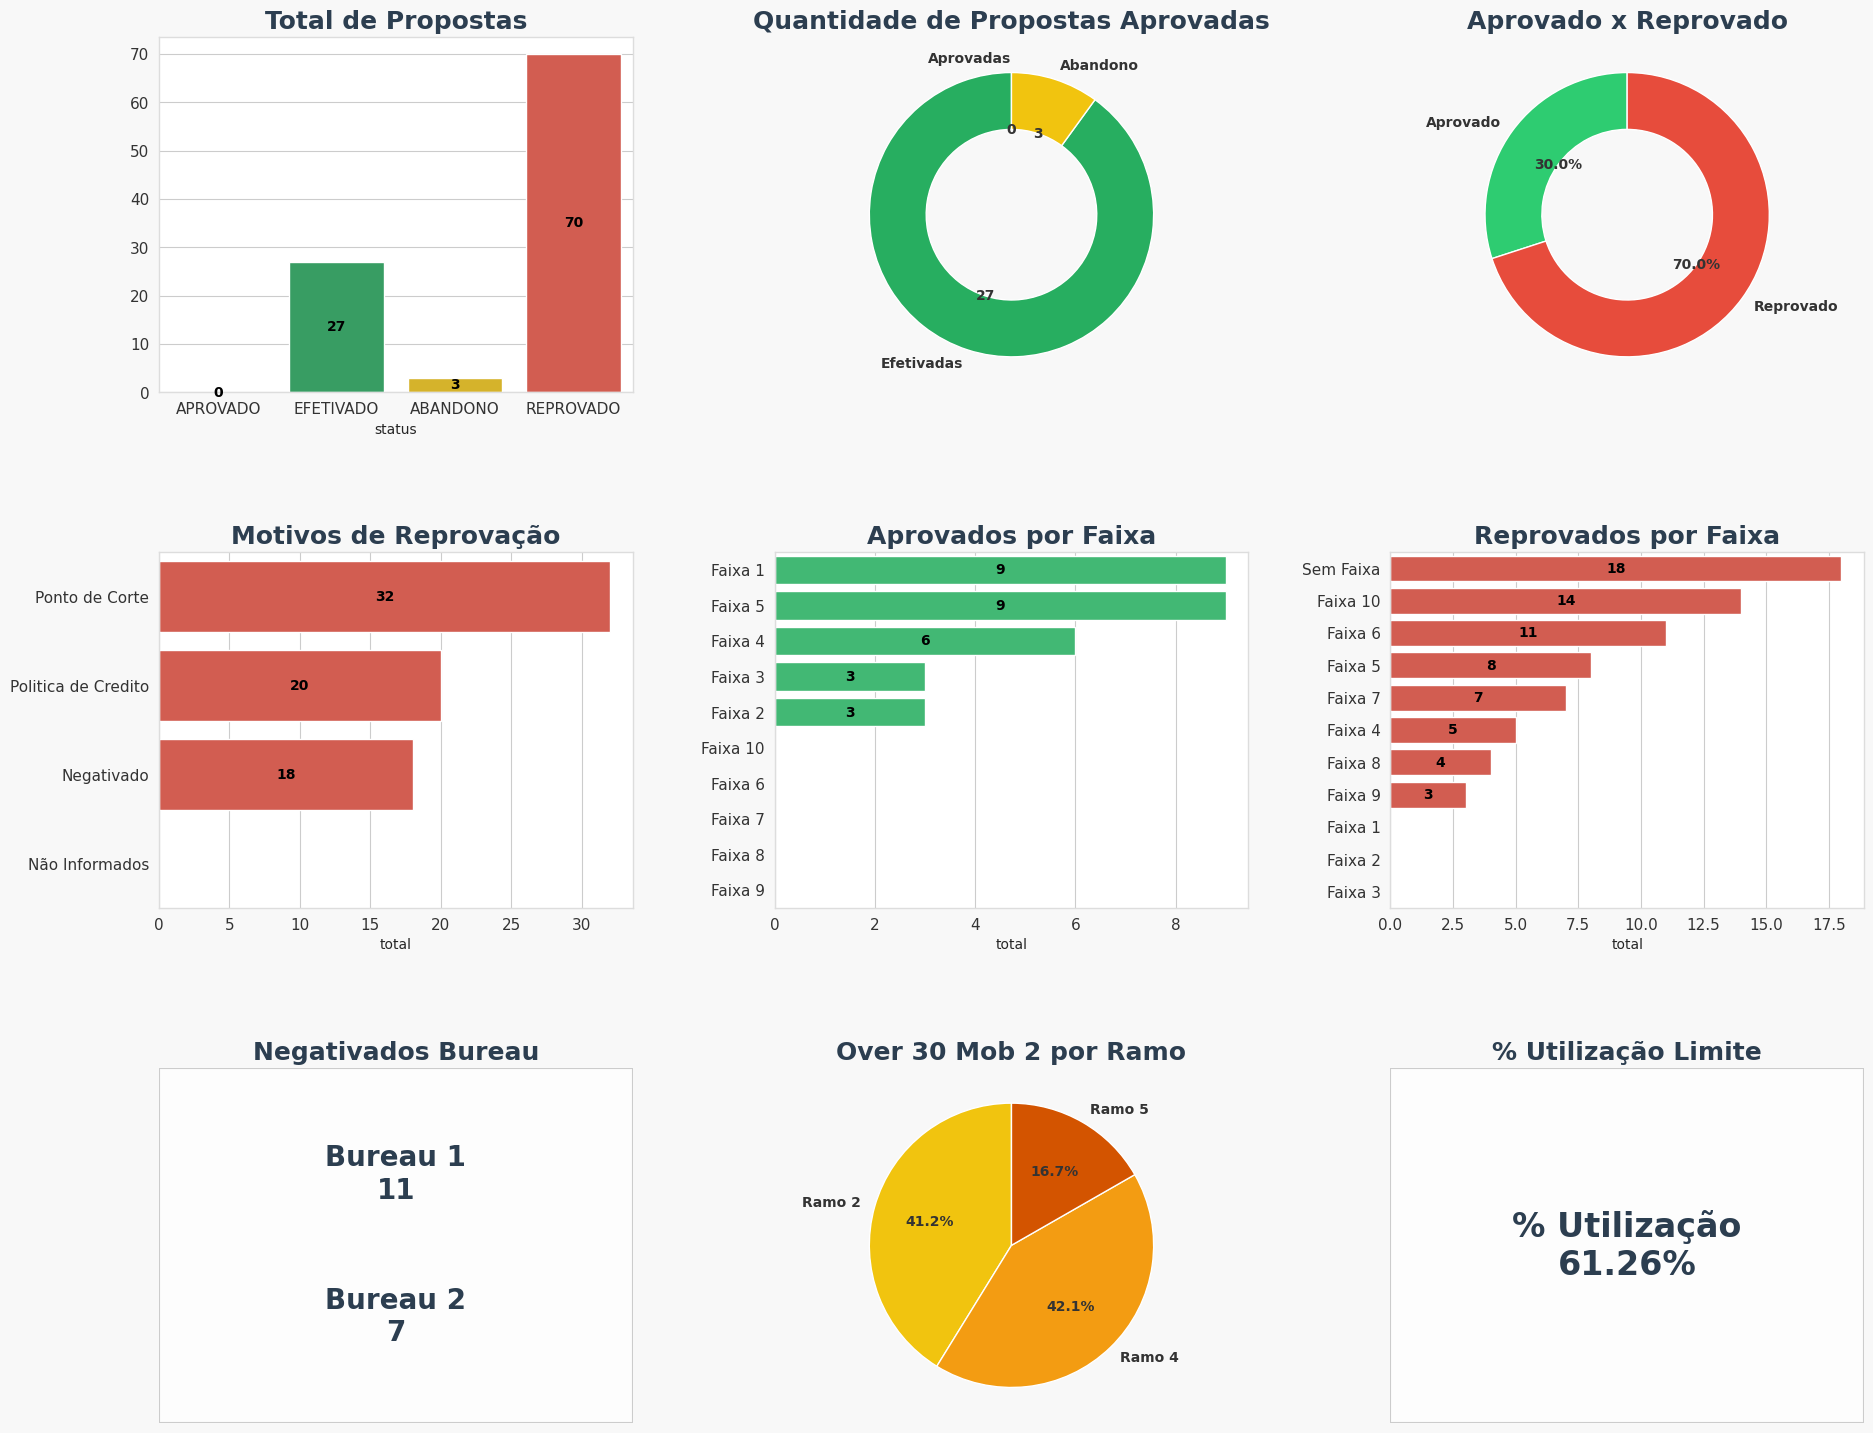

In [ ]:


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import HTML, display

# Paletas de cores
sns.set_style("whitegrid")
palette_bar = sns.color_palette("Set2")
palette_pie = sns.color_palette("pastel")

# ========== CABEÇALHO ==========
display(HTML(f"""
<div style='display:flex; justify-content:center; margin:40px 0;'>
    <div style='width:60%; border:1px solid #cccccc; background-color:#ffffff;
                padding:25px; border-radius:10px;
                box-shadow: 0 2px 8px rgba(0,0,0,0.08); text-align:center;'>
        <h1 style='font-size:34px; font-weight:bold; color:#2c3e50; margin:0;'>
            Dashboard Dados Crédito
        </h1>
    </div>
</div>
"""))


# ========== TABELA ==========
tabela_exec = pd.DataFrame([
    ['% Taxa Aprovação', f"{kpi_taxa_aprovacao.iloc[0,0]}%"],
    ['% Taxa Aprovação Esp', f"{kpi_taxa_aprovacao_esp.iloc[0,0]}%"],
    ['% Taxa Efetivação', f"{kpi_taxa_efetivacao.iloc[0,0]}%"],
    ['% Taxa Abandono', f"{kpi_taxa_abandono.iloc[0,0]}%"],
    ['% Taxa Negativação', f"{kpi_taxa_negativacao.iloc[0,0]}%"],
    ['% Política Crédito', f"{kpi_taxa_politica.iloc[0,0]}%"],
    ['% Ponto de Corte', f"{kpi_taxa_ponto_corte.iloc[0,0]}%"],
    ['% Ativação', f"{kpi_taxa_ativacao.iloc[0,0]}%"],
    ['R$ Limite Concedido', f"R$ {kpi_limite_concedido.iloc[0,0]:,.2f}"],
    ['R$ Primeira Compra', f"R$ {kpi_primeira_compra.iloc[0,0]:,.2f}"],
    ['% Utilização Limite', f"{kpi_utilizacao_limite.iloc[0,0]}%"]
], columns=['Indicador', 'Valor'])

# Estilo HTML
html_table = tabela_exec.style.set_table_styles([
    {'selector': 'thead th',
     'props': [('background-color', '#f7f7f7'), ('color', '#2c3e50'),
               ('font-weight', 'bold'), ('font-size', '18px'),
               ('text-align', 'center'), ('padding', '8px'),
               ('border-bottom', '2px solid #ccc')]},
    {'selector': 'tbody td',
     'props': [('padding', '10px'), ('border', '1px solid #e0e0e0'),
               ('font-size', '16px'), ('text-align', 'center')]},
    {'selector': 'tbody tr:nth-child(even)',
     'props': [('background-color', '#f9f9f9')]},
    {'selector': 'tbody tr:nth-child(odd)',
     'props': [('background-color', '#ffffff')]},
], overwrite=False).hide(axis='index').set_properties(
    subset=['Indicador'], **{'color': '#2c3e50', 'font-weight': 'bold', 'text-align':'left'}
).set_properties(
    subset=['Valor'], **{'color': '#2a7f62', 'font-weight': 'bold', 'font-size':'18px'}
).to_html()

# Exibição de tabela
display(HTML(f"""
<center>
<div style='width:60%; max-width:800px; border:1px solid #cccccc; background-color:#ffffff;
            padding:25px; border-radius:10px;
            box-shadow: 0 2px 8px rgba(0,0,0,0.08); text-align:center; margin:30px 0;'>
    {html_table}
</div>
</center>
"""))

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# ========== GRADE DE GRÁFICOS ========== #
fig, axes = plt.subplots(3, 3, figsize=(22, 18), facecolor='#f8f8f8')
axes = axes.flatten()

# Ajuste de espaçamento
plt.subplots_adjust(wspace=0.3, hspace=0.45)

# Paleta de labels
palette_semantica = {
    'APROVADO': '#2ecc71',     # verde claro
    'REPROVADO': '#e74c3c',    # vermelho claro
    'EFETIVADO': '#27ae60',    # verde médio
    'ABANDONO': '#f1c40f',     # amarelo
    'NEUTRO': '#3498db'        # azul
}
palette_bar = [palette_semantica.get(x, '#3498db') for x in kpi_total_segmentado['status'].unique()]

# Estilo clean com bordas suaves
for ax in axes:
    ax.set_facecolor('#ffffff')
    for spine in ax.spines.values():
        spine.set_edgecolor('#dddddd')
        spine.set_linewidth(1)
    ax.tick_params(colors='#333333', labelsize=11)

# ===== Total de Propostas =====
sns.barplot(data=kpi_total_segmentado, x='status', y='total', ax=axes[0],
            hue='status', dodge=False, palette=palette_bar, legend=False)
axes[0].set_title("Total de Propostas", fontsize=18, fontweight='bold', color='#2c3e50')
axes[0].set_ylabel("")
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d', label_type='center', fontweight='bold', color='black')

# ===== Quantidade de Propostas Aprovadas =====
qtd_aprov = kpi_total_segmentado_aprov[kpi_total_segmentado_aprov['status']=='APROVADO']['total'].sum()
qtd_efet = kpi_total_segmentado_aprov[kpi_total_segmentado_aprov['status']=='EFETIVADO']['total'].sum()
qtd_aband = kpi_total_segmentado_aprov[kpi_total_segmentado_aprov['status']=='ABANDONO']['total'].sum()

total = qtd_aprov + qtd_efet + qtd_aband

axes[1].pie(
    [qtd_aprov, qtd_efet, qtd_aband],
    labels=['Aprovadas', 'Efetivadas', 'Abandono'],
    autopct=lambda p: f'{int(round(p/100*total))}',  # Exibir apenas valores absolutos
    startangle=90,
    wedgeprops={'width':0.4},
    colors=['#2ecc71','#27ae60','#f1c40f'],
    textprops={'weight':'bold', 'color':'#333'}
)

axes[1].set_title("Quantidade de Propostas Aprovadas", fontsize=18, fontweight='bold', color='#2c3e50')


# ===== Aprovado x Reprovado =====
aprov = kpi_total_aprovxreprov[kpi_total_aprovxreprov['status']=='APROVADO']['total'].sum()
reprov = kpi_total_aprovxreprov[kpi_total_aprovxreprov['status']=='REPROVADO']['total'].sum()

axes[2].pie(
    [aprov, reprov],
    labels=['Aprovado', 'Reprovado'],
    autopct=lambda p: f'{p:.1f}%' if p > 0 else '',
    startangle=90,
    wedgeprops={'width':0.4},
    colors=[palette_semantica['APROVADO'], palette_semantica['REPROVADO']],
    textprops={'weight':'bold', 'color':'#333'}
)

axes[2].set_title("Aprovado x Reprovado", fontsize=18, fontweight='bold', color='#2c3e50')


# ===== Motivos de Reprovação =====
sns.barplot(data=kpi_reprovadas_motivos.sort_values('total', ascending=False),
            y='motivo_reprovacao', x='total', ax=axes[3],
            color=palette_semantica['REPROVADO'], legend=False)
axes[3].set_title("Motivos de Reprovação", fontsize=18, fontweight='bold', color='#2c3e50')
axes[3].set_ylabel("")
for container in axes[3].containers:
    axes[3].bar_label(container, fmt=lambda v: f'{int(v)}' if v>0 else '', label_type='center', fontweight='bold', color='black')

# ===== Aprovados por Faixa =====
sns.barplot(data=kpi_aprovados_fxscore.sort_values('total', ascending=False),
            y='fx_score', x='total', ax=axes[4], color=palette_semantica['APROVADO'])
axes[4].set_title("Aprovados por Faixa", fontsize=18, fontweight='bold', color='#2c3e50')
axes[4].set_ylabel("")
for container in axes[4].containers:
    axes[4].bar_label(container, fmt=lambda v: f'{int(v)}' if v>0 else '', label_type='center', fontweight='bold', color='black')

# ===== Reprovados por Faixa =====
sns.barplot(data=kpi_reprovados_fxscore.sort_values('total', ascending=False),
            y='fx_score', x='total', ax=axes[5], color=palette_semantica['REPROVADO'])
axes[5].set_title("Reprovados por Faixa", fontsize=18, fontweight='bold', color='#2c3e50')
axes[5].set_ylabel("")
for container in axes[5].containers:
    axes[5].bar_label(container, fmt=lambda v: f'{int(v)}' if v>0 else '', label_type='center', fontweight='bold', color='black')

# ===== Cartão Bureau =====
# Extrair valores da query de negativados por bureau
valor_b1 = kpi_negativados_bureau.loc[kpi_negativados_bureau['bureau']=='Bureau 1', 'total'].sum()
valor_b2 = kpi_negativados_bureau.loc[kpi_negativados_bureau['bureau']=='Bureau 2', 'total'].sum()
axes[6].axis('off')
axes[6].add_patch(plt.Rectangle((0,0),1,1, fill=True, color='#fdfdfd', ec='#cccccc', lw=1.5))
axes[6].text(0.5, 0.7, f"Bureau 1\n{valor_b1}", ha='center', va='center', fontsize=20, weight='bold', color='#2c3e50')
axes[6].text(0.5, 0.3, f"Bureau 2\n{valor_b2}", ha='center', va='center', fontsize=20, weight='bold', color='#2c3e50')
axes[6].set_title("Negativados Bureau", fontsize=18, fontweight='bold', color='#2c3e50')

# ===== Over 30 Mob 2 =====
df_ramo = kpi_over30_ramo[kpi_over30_ramo['over30_mob2'] > 0]
axes[7].pie(df_ramo['over30_mob2'], labels=df_ramo['ramo_sistema'], autopct=lambda p: f'{p:.1f}%' if p > 0 else '',
            startangle=90, colors=['#f1c40f','#f39c12','#d35400'],
            textprops={'weight':'bold', 'color':'#333'})
axes[7].set_title("Over 30 Mob 2 por Ramo", fontsize=18, fontweight='bold', color='#2c3e50')

# ===== % Utilização =====
axes[8].axis('off')
axes[8].add_patch(plt.Rectangle((0,0),1,1, fill=True, color='#fdfdfd', ec='#cccccc', lw=1.5))
axes[8].text(0.5, 0.5, f"% Utilização\n{kpi_utilizacao_limite.iloc[0,0]}%", ha='center', va='center', fontsize=24, weight='bold', color='#2c3e50')
axes[8].set_title("% Utilização Limite", fontsize=18, fontweight='bold', color='#2c3e50')

plt.show()


### **Parte Final - Considerações da base e teste.**

#### **Insights**

*   Conversão Geral de Propostas
Considerando uma conversão geral de 30% o funil tem se mostrado saudável, porém com oportunidades de melhoria visto que dos 30% convertido, 10% destes (3% total) são  propostas abandonadas que poderiam incrementar o funil.
*   Reprovação em 70% do total onde, desses 70%, ~46% tem um perfil de política de Score fora das regraas de negócio (corte) + ~29% de Política de Crédito totalizando ~75% das 70 propostas recusadas. É importante entender quais regras estão bloqueando crédito e qual o nível de sensibilidade para maior oferta de crédito.
*   Faixas de Score em 1 e 5 indicando que o modelo libera bem nas pontas do Score, Reprovados concentrados nas faixas intermediárias e baixas o que pode apontar inadimplência, alto nível de endividamento e/ou baixo perfil de crédito nessas áreas.
*   Bureau 1 tem 61% dos negativados frente a 39% do Bureau 2, preciso avaliar se está mais conservador que o Bureau 2 e se isso alinha-se com perfil da empresa e histórico.
*   Utilização média inicial de 63% do limite concedido o que indica que está sendo usado próximo da necessidade real.
*   Se houver inadimplência baixa, pode-se testar aumentos graduais de limite para clientes com maior utilização inicial

#### **Considerações Finais:**

Funil parece equilibrado, mas com espaço de redução de propostas abandonadas e calibragem das políticas de crédito (a entender) - Ponto de corte e política de crédito concentrando recusas.
Alta taxa de utilização inicial positiva
Inadimplência concentrada em poucos Ramos.
Bureau 1 Mais restritivo.


#### **Dificuldades que enfrentei e reflexões:**

Instalação do Oracle para utilização de sintaxe, tive que encontrar outra forma de realizar.
Necessidade de maior entendimento dos dados e bases, tentei dar o máximo para cálculo dos valores e lógica aplicada.
Optei por usar o notebook para resposta pois seria mais desafiador e englobaria mais pontos de processo ETL. Ainda tenho muito a evoluir, mas espero ter demonstrado potencial.


## **Obrigado!**

